# Klasifikasi Sampah - Interactive Scanner

Upload waste images and detect objects using YOLOv8 model.

**Usage**: Run cells sequentially (1 → 2 → 3)

**Requirements**: Trained model at `../models/best_model.pt`

In [1]:
# Setup - Import all dependencies and load model
import io
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from PIL import Image
from IPython.display import display
from ultralytics import YOLO

# Load model
MODEL_PATH = '../models/best_model.pt'
if not Path(MODEL_PATH).exists():
    print(f"❌ Model not found: {MODEL_PATH}")
    print("   Train model first: python train.py")
    model = None
else:
    model = YOLO(MODEL_PATH)
    print(f"✓ Model loaded: {MODEL_PATH}")
    print(f"  Classes: {list(model.names.values())}")

✓ Model loaded: ../models/best_model.pt
  Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


📁 Upload an image:


FileUpload(value=(), accept='image/*', description='Upload Image')

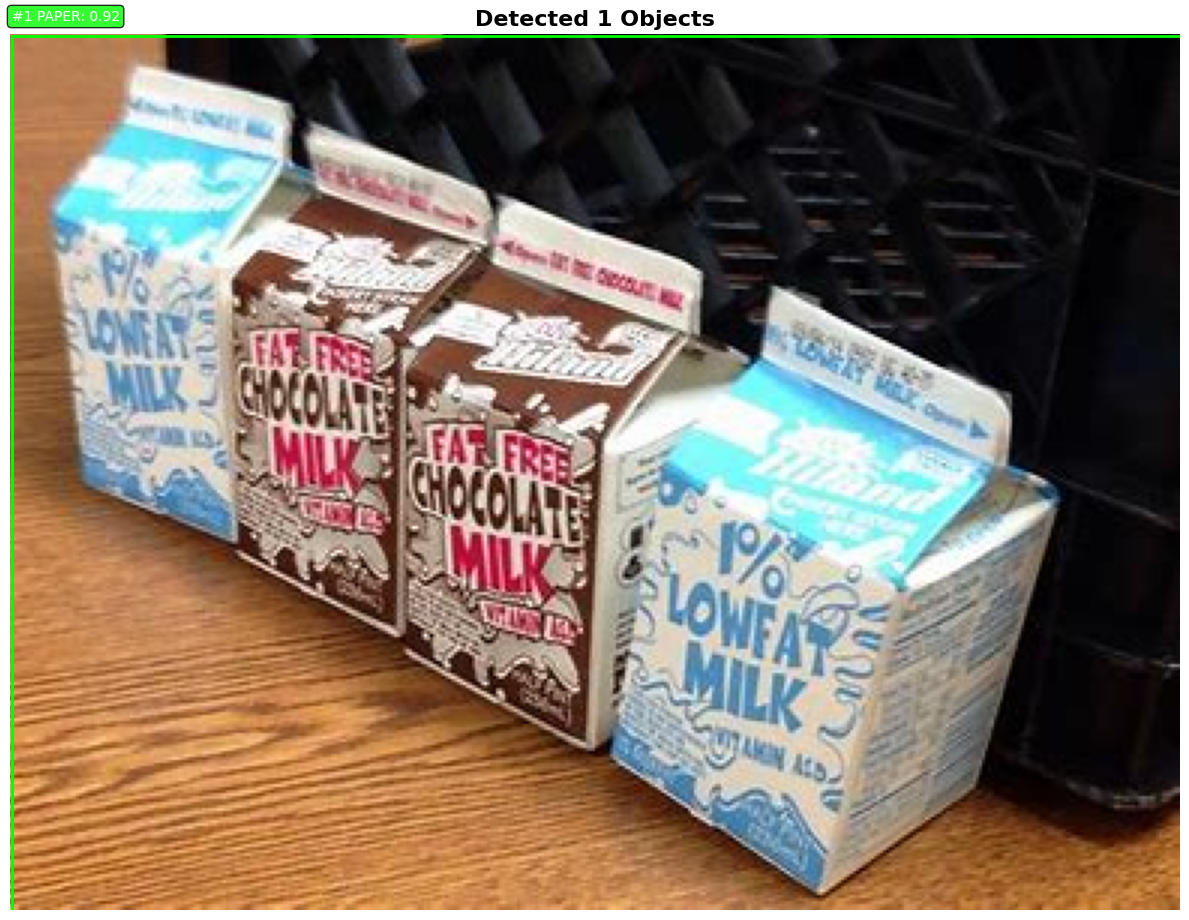

,#,Class,Conf
0,1,paper,0.915


In [3]:
# Upload and Detect - Upload image then detect objects
uploader = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Image')
print("📁 Upload an image:")
display(uploader)

def process_image(change):
    """Process uploaded image and detect objects"""
    if not uploader.value:
        print("No image uploaded")
        return
    
    if not model:
        print("❌ Model not loaded")
        return
    
    # Get image data
    if isinstance(uploader.value, tuple) and len(uploader.value) > 0:
        file_info = uploader.value[0]
        image_data = file_info['content']
    elif isinstance(uploader.value, dict):
        file_info = list(uploader.value.values())[0]
        image_data = file_info['content']
    else:
        print("Invalid file format")
        return
    
    # Load image
    image = Image.open(io.BytesIO(image_data))
    
    # Run detection
    results = model(image, conf=0.25, verbose=False)
    
    # Display results
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)
    
    detections = []
    for result in results:
        for idx, box in enumerate(result.boxes, 1):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            class_name = result.names[cls]
            
            # Draw box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                                     edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            
            # Label
            label = f"#{idx} {class_name.upper()}: {conf:.2f}"
            ax.text(x1, y1-5, label, color='white', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8))
            
            detections.append({'#': idx, 'Class': class_name, 'Conf': f"{conf:.3f}"})
    
    ax.axis('off')
    ax.set_title(f'Detected {len(detections)} Objects', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Results table
    if detections:
        df = pd.DataFrame(detections)
        print("\n📊 Detection Results:")
        display(df)
        print(f"\n✓ Found {len(detections)} object(s)")
    else:
        print("⚠ No objects detected")

# Auto-process when image uploaded
uploader.observe(process_image, names='value')

## Usage Instructions

1. **Run Cell 1**: Load model and dependencies
2. **Run Cell 2**: Upload widget will appear
3. **Upload Image**: Click "Upload Image" and select waste image
4. **Auto-Detect**: Results appear automatically after upload

## Troubleshooting

- **Model not found**: Run `python train.py` first
- **No detections**: Image quality may be poor or threshold too high
- **Error loading**: Restart kernel and run cells again

## Tips

- Use clear, well-lit images
- Model confidence threshold: 0.25 (25%)
- Supported formats: JPG, PNG